# Import libraries

In [49]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pywt

import os
import shutil

%matplotlib inline

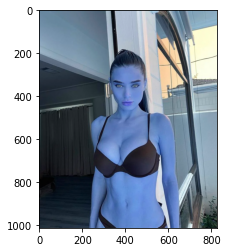

In [2]:
lana_rhoades_img = cv2.imread('./test_images/Lana_Rhoades1.jpg')
lana_rhoades_img.shape
plt.imshow(lana_rhoades_img)

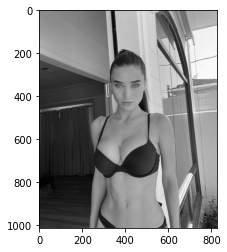

In [3]:
gray_lr = cv2.cvtColor(lana_rhoades_img, cv2.COLOR_BGR2GRAY)
gray_lr.shape
plt.imshow(gray_lr, cmap='gray')

### I will going to detect the face from this image and also the eyes. I will use this kind of detection to train my model, it is called haar cascade classifier. In general, it detects face and eyes. 

### Load haar cascade classifiers for face and eyes.

In [4]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

In [5]:
# check how it works on the image of Lana Rhoades
lana_rhoades_coords = face_cascade.detectMultiScale(gray_lr, 1.3, 5)  # returns region of the face
lana_rhoades_coords

array([[307, 268, 206, 206]])

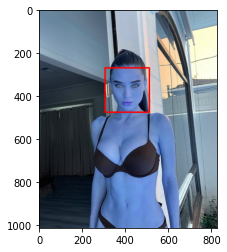

In [6]:
x1, y1, x2, y2 = lana_rhoades_coords[0]
lanas_face_img = cv2.rectangle(lana_rhoades_img, (x1, y1), (x1 + x2, y1 + y2), (255, 0, 0), 6)
plt.imshow(lanas_face_img)

### Now I will detect eyes and draw rectangles on them.

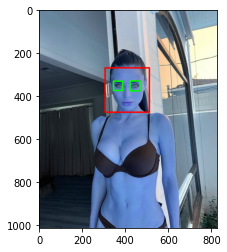

In [10]:
for (x1, y1, x2, y2) in lana_rhoades_coords:
    lanas_face_img = cv2.rectangle(lana_rhoades_img, (x1, y1), (x1 + x2, y1 + y2), (255, 0, 0), 6)
    roi_gray = gray_lr[y1 : y1 + y2, x1 : x1 + x2]
    roi_color = lanas_face_img[y1 : y1 + y2, x1 : x1 + x2]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex1, ey1, ex2, ey2) in eyes:
        cv2.rectangle(roi_color, (ex1, ey1) , (ex1 + ex2, ey1 + ey2), (0, 255, 0), 6)
        
plt.figure()
plt.imshow(lanas_face_img, cmap='gray')
plt.show()

### Illustrating detected face (region of interest)

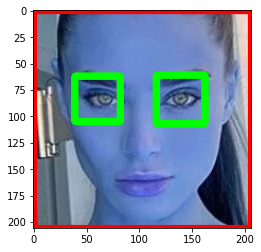

In [11]:
plt.imshow(roi_color)

In [47]:
def get_cropped_image_if_two_eyes(image_path):
    """
    function detects two eyes on the image and cropp it, returns coordinates of the face
    """
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x1, y1, x2, y2) in faces:
        roi_gray = gray[y1 : y1 + y2, x1 : x1 + x2]
        roi_color = img[y1 : y1 + y2, x1 : x1 + x2]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

### Let's try this function on the original image above  

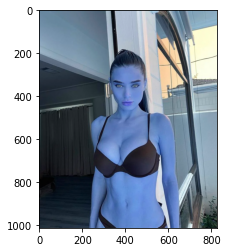

In [13]:
original_lana_rhoades = cv2.imread('./test_images/Lana_Rhoades1.jpg')
plt.imshow(original_lana_rhoades)

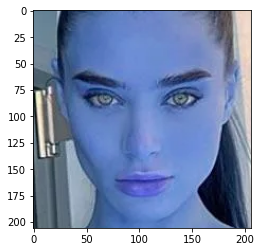

In [14]:
cropped_image = get_cropped_image_if_two_eyes('./test_images/Lana_Rhoades1.jpg')
plt.imshow(cropped_image)

### Now I will try to use image with not clearly visiable eyes and let's see how function will behave.

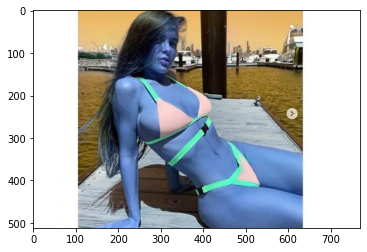

In [15]:
img_obstructed = cv2.imread('./test_images/Lana_Rhoades2.jpeg')
plt.imshow(img_obstructed)

In [16]:
cropped_image_no_two_eyes = get_cropped_image_if_two_eyes('./test_images/Lana_Rhoades2.jpeg')
cropped_image_no_two_eyes

### It can be observed that function returned nothing, therefore there weren't detect two eyes.

### Create a folder for cropped images. 

In [32]:
path_to_data = './dataset/'
path_to_cropped_data = './dataset/cropped/'

In [37]:
img_dirs = []  # image directories

for entry in os.scandir(path_to_data):  # goes through all subdirectories
    if entry.is_dir():
        img_dirs.append(entry.path)

In [38]:
if os.path.exists(path_to_cropped_data):  # generates cropped folder if it doesn't exist
    shutil.rmtree(path_to_cropped_data)  # if it already exists, removes it
os.mkdir(path_to_cropped_data)

In [39]:
img_dirs

['./dataset/Eva_Elfie',
 './dataset/Lana_Rhoades',
 './dataset/Nancy_Ace',
 './dataset/Sosa_Zola']

In [48]:
cropped_images_dirs = []  # silimar to image directories but it contains cropped images
pornstar_files_name = {}  # file name of each pornstar

# going to iterate each of those image directories 
for img_dir in img_dirs:
    count = 1
    pornstar_name = img_dir.split('/')[-1]
    pornstar_files_name[pornstar_name] = []
    for entry in os.scandir(img_dir):
        try:
            roi_color = get_cropped_image_if_two_eyes(entry.path)
        except:
            pass
        if roi_color is not None:  # two eyes clearly visiable
            cropped_folder = path_to_cropped_data + pornstar_name  # folder of each cropped pornstar
            if not os.path.exists(cropped_folder):  # if there is not such a folder, create it
                os.makedirs(cropped_folder)
                cropped_images_dirs.append(cropped_folder)
                print("Generating cropped images in folder:", cropped_folder)
            cropped_file_name = pornstar_name + str(count) + ".png"
            cropped_file_path = cropped_folder + '/' + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)  # create cropped image
            pornstar_files_name[pornstar_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder: ./dataset/cropped/Eva_Elfie
Generating cropped images in folder: ./dataset/cropped/Lana_Rhoades
Generating cropped images in folder: ./dataset/cropped/Nancy_Ace
Generating cropped images in folder: ./dataset/cropped/Sosa_Zola


### Now I will manually check cropped images

### Let's use wavelet transformation on this images

In [50]:
# code from openCV doc
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

### Try this transformation on a regular picture

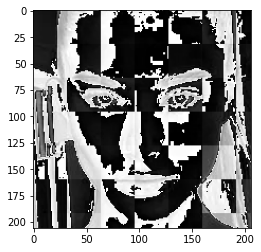

In [51]:
lana_rhoades_har = w2d(cropped_image, 'db1', 5)
plt.imshow(lana_rhoades_har, cmap='gray')

In [53]:
class_dict, count = {}, 0
for pornstar_name in pornstar_files_name.keys():
    class_dict[pornstar_name] = count
    count += 1
class_dict

{'Eva_Elfie': 0, 'Lana_Rhoades': 1, 'Nancy_Ace': 2, 'Sosa_Zola': 3}

In [56]:
X, y = [], []

for pornstar_name, training_files in pornstar_files_name.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:  # because i deleted some of images manually and dictionary is not updated, error could occur
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))  # images could have different size, so i resize them
        img_haar = w2d(img, 'db1', 5)
        scalled_img_haar = cv2.resize(img_haar, (32, 32))
        # stack these images vertically
        combined_image = np.vstack((scalled_raw_img.reshape(32 * 32 * 3, 1), scalled_img_haar.reshape(32 * 32, 1)))
        X.append(combined_image)
        y.append(class_dict[pornstar_name])

In [58]:
len(X[0])  # check the image, 32*32*3 + 32*32

4096

In [59]:
X[0]

array([[ 76],
       [ 83],
       [102],
       ...,
       [ 84],
       [ 23],
       [250]], dtype=uint8)

In [60]:
# convert vector X into a float vector
X = np.array(X).reshape(len(X), 4096).astype(float)

In [61]:
X[0]

array([ 76.,  83., 102., ...,  84.,  23., 250.])